---
layout: page
title: Tesla
---

In [1]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown

from data_loader import load_data
from chart_format import StandardChart, LogChart, PercentileChart
from data_functions import Percentiles

Tesla’s IPO on the NASDAQ was on 29 June 2010. The Tesla share price has extensive periods of high volatility and equally compressed periods of extreme gains.

The share price and "true" market value of the company frequently have a large disconnect, as institutional fund managers focus on "short term" 12 month financial targets, often refusing to place any value on long term growth potential - at least until the profit numbers start showing up in the quarterly financials.

In [2]:
""" Load data
"""
sx_symbol = 'TSLA'
sx_tz = pytz.timezone('America/New_York')

from_date = datetime.datetime(1960, 1, 1) 
from_date = sx_tz.localize(from_date)

to_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
to_date = sx_tz.localize(to_date)

csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/'+ quote(sx_symbol.upper()) +'?period1=' + str(int(from_date.timestamp())) + '&period2=' + str(int(to_date.timestamp())) + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = f'../data/{sx_symbol.lower()}_HistoricalData.csv'
max_age_days = 1

df = load_data(csv_url, local_file, max_age_days)

In [3]:
""" Data Transformation """
data_column = 'Adj Close'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df[data_column].last_valid_index() # pandas timestamp

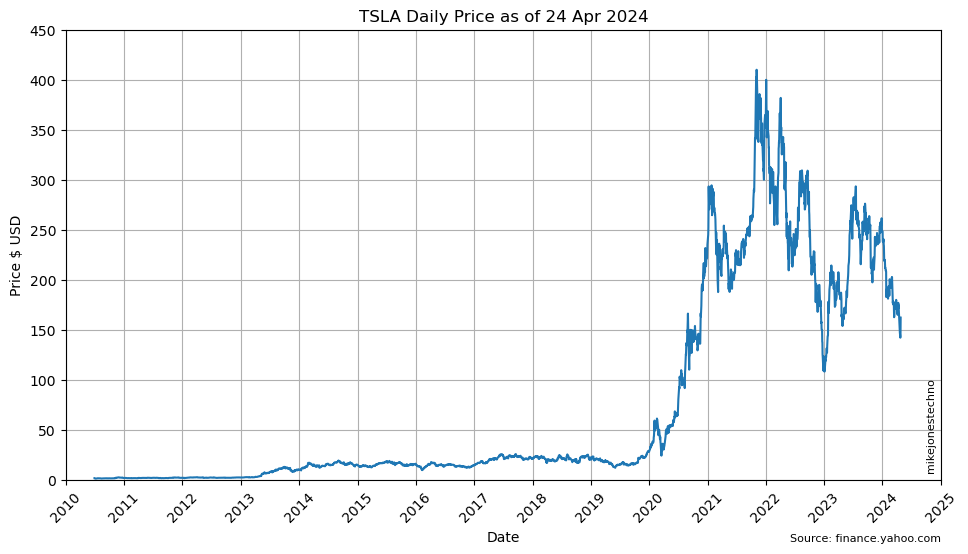

In [4]:
""" Show simple chart """

chart_params = {
    'chart_title': sx_symbol + ' Daily Price as of ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: finance.yahoo.com', 
    'y_label': 'Price $ USD', 
    'y_ticks': 50,
    'x_label': 'Date', 
    'x_ticks': 1,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[0]['color'])

plt.show()

The compound annual growth over time appears to be exponential growth. Plotting the **same data** with a logarithmic y-axis scale helps visualize the bursts of growth in earlier years that would otherwise be hidden by the volatility of spikes in later years.

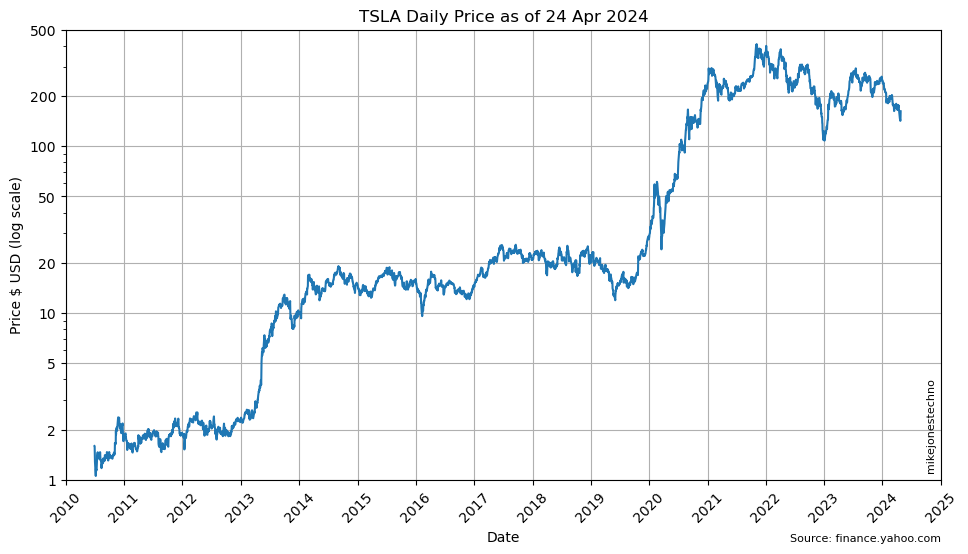

In [5]:
""" y-axis log scale """
log_chart_params = chart_params.copy()
log_chart_params['y_label'] = chart_params['y_label'] + ' (log scale)'
log_chart_params['y_ticks'] = [1, 2, 5, 10, 20, 50, 100, 200, 500]
log_chart = LogChart(**log_chart_params)
plt, colors = log_chart.base_chart(df)
plt.plot(df.index, df[data_column], color=colors[0]['color'])
plt.show()

The logarithmic scale shows the price was slightly increasing from IPO in 2010 to 2013 before a sudden 5x jump between 2013 and 2014 from $2 to $10 (split adjusted).

The jump was likely attributed to the Model S launch in 2012 and the first quarter of profit since the company was founded in 2003. The jump was followed by strong 2x growth in the five year period between 2014 and 2019, before another sudden 10x jump between 2020 and 2021 from $20 to $200 (split adjusted).

The second jump is likely attibuted to the Model 3 production ramp, and the final validation of Tesla as a profitable auto maker at scale, although at this price Tesla exceeds the market capitalization of the top eight global auto makers... combined.

The price has been highly volatile since 2021 generally trending sideways.

For comparison, the high performance S&P 500 Index only shows 5x growth over a ten year or longer period. The 100x growth in ten years from 2011 to 2021 is "rare".

In [6]:
""" Calculate and print percentiles table """
""" Year over Year (YoY) change based on 252 trading days per year """
periods_per_year = 252
df['YoY'] = df[data_column].pct_change(periods=periods_per_year)*100
multi_years = [1, 5, 10]
percentiles = Percentiles(df, 'YoY', periods_per_year, multi_years)
df = percentiles.calculate_percentiles(df)
df_last_percentiles = percentiles.calculate_last_percentiles(df)

In [7]:
percentiles.display_percentile_intro()


Calculating the 25th and 75th percentile over a multi year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.
    

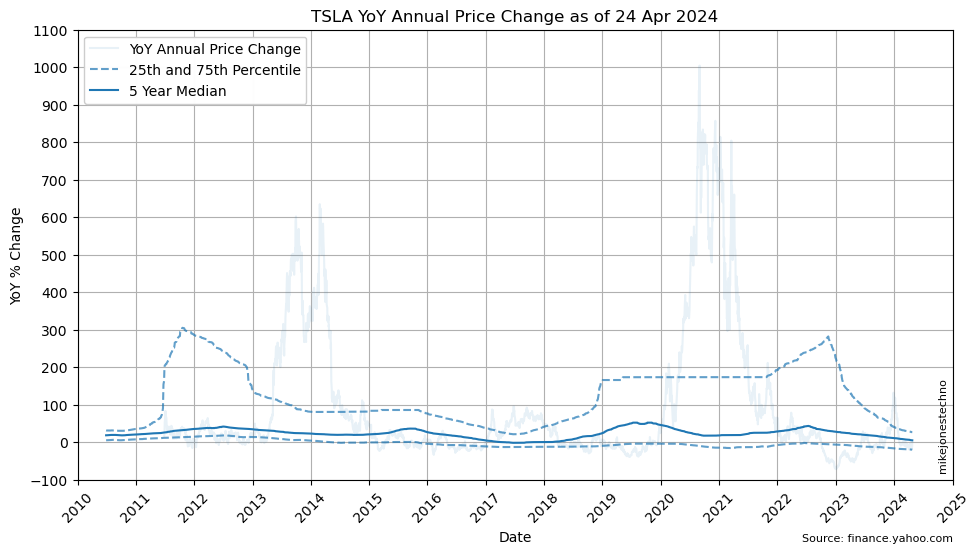

In [8]:
chart_params['chart_title'] = sx_symbol + ' YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y')
chart_params['data_column'] = 'YoY'
chart_params['x_ticks'] = 1
chart_params['y_label'] = 'YoY % Change'
chart_params['y_ticks'] = 100
chart_params['color_index'] = 0
chart_params['legend_location'] = 'upper left'
percentile_chart = PercentileChart(percentiles.percentiles, percentiles.multi_years[1], **chart_params)
plt = percentile_chart.plot_percentiles(df) 
plt.show()

In [9]:
percentiles.display_percentile_summary(df_last_percentiles, 'YoY change')
percentiles.display_dataframe_table(df_last_percentiles)


Over the last 5 years the median (50th percetile) YoY change is 25.15%.

Over the last 10 years the median (50th percetile) YoY change is 16.21%.
    

Years,25th percentile,50th percentile,75th percentile
1,-12.56,-3.67,18.79
5,-12.15,25.15,173.34
10,-10.12,16.21,69.90


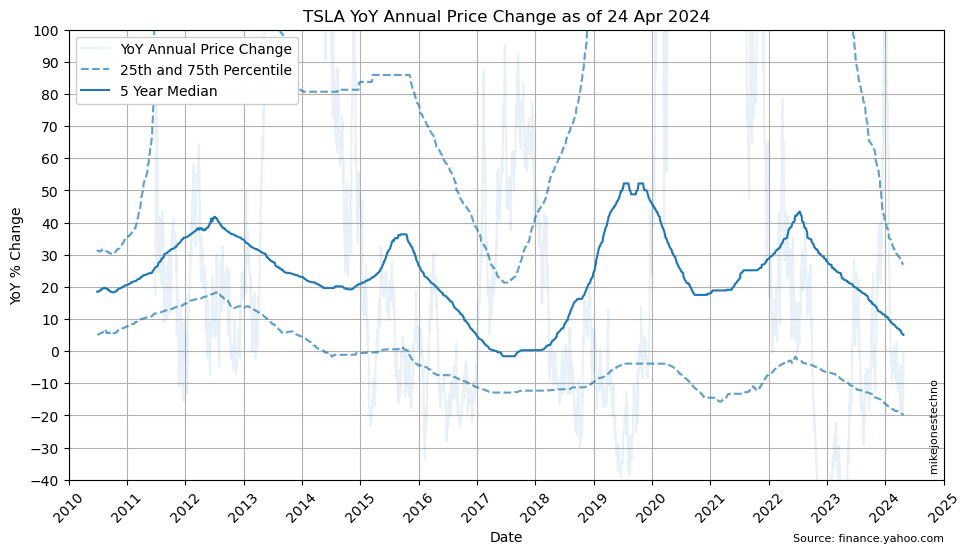

In [10]:
""" Change chart variables to plot from 1995 and multi year window not extended multi year window """
chart_params['x_ticks'] = 1
chart_params['y_ticks'] = 10
chart_params['bottom_limit'] = -40
chart_params['top_limit'] = 100
percentile_chart = PercentileChart(percentiles.percentiles, percentiles.multi_years[1], **chart_params)
plt = percentile_chart.plot_percentiles(df)
plt.show()

In [11]:
display(Markdown(f"""
> ℹ Given the relatively short history, the data suggests reasonable confidence using a baseline long term performance around { "{:,.0f}".format(df_last_percentiles.loc[percentiles.multi_years[-1], percentiles.percentiles[1]]) }% with uncertainty or risk that TSLA may have bursts of extreme growth with periods of volatility for several years at a time. Note this does not take inflation into consideration.
"""))


> ℹ Given the relatively short history, the data suggests reasonable confidence using a baseline long term performance around 16% with uncertainty or risk that TSLA may have bursts of extreme growth with periods of volatility for several years at a time. Note this does not take inflation into consideration.


In [12]:
%%capture
# Magic store dataframe to share with combo notebook
df_tsla = df
%store df_tsla